# Evaluation Notebook
This notebook loads a JSONL file containing entries with `query`, `gold_answer`, and `predicted_answer`, and computes evaluation metrics:
- Exact Match (EM)
- Numeric tolerance match (absolute + relative)
- Token-level F1


In [1]:
import json
import math
from typing import List, Dict


def load_jsonl(path: str) -> List[Dict]:
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def normalize(text: str) -> str:
    return text.strip().lower() if isinstance(text, str) else str(text)

def exact_match(gold, pred):
    return normalize(gold) == normalize(pred)

def numeric_match(gold, pred, abs_tol=1e-6, rel_tol=1e-3):
    try:
        g = float(gold)
        p = float(pred)
        return abs(g - p) <= abs_tol or abs(g - p) / max(abs(g), 1e-9) <= rel_tol
    except:
        return False

def token_f1(gold, pred):
    g_tokens = normalize(gold).split()
    p_tokens = normalize(pred).split()
    if len(g_tokens) == 0 or len(p_tokens) == 0:
        return 0
    overlap = len(set(g_tokens) & set(p_tokens))
    if overlap == 0:
        return 0
    precision = overlap / len(p_tokens)
    recall = overlap / len(g_tokens)
    return 2 * precision * recall / (precision + recall)

def mae_error(gold,pred):
        try:
            g = float(gold)
            p = float(pred)
            return abs(p - g)
        except:
            return None
        
def rmse_component(gold, pred):
    """
    Returns the squared error (p - g)^2 for one gold/pred pair.
    Returns None if not numeric.
    """
    try:
        g = float(gold)
        p = float(pred)
        return (p - g) ** 2
    except:
        return None

        
def numeric_distances(gold, pred):
    """
    Returns (abs_distance, relative_distance) for one gold/pred pair.
    Returns (None, None) if not numeric.
    """
    try:
        g = float(gold)
        p = float(pred)
        abs_dist = abs(p - g)
        rel_dist = abs_dist / (abs(g) + 1e-9)
        return abs_dist, rel_dist
    except:
        return None, None



In [2]:
import pandas as pd
lst = []

In [3]:
import math

# ---------------------------------------------------------
# 1. Basic parser: convert whitespace-separated table into columns
# ---------------------------------------------------------

def parse_table_to_columns(text, expected_cols=None):
    """
    Parse a whitespace-separated table into column lists.

    Features:
    - If expected_cols is provided, the parser will reshape rows to that width.
    - Supports optional headers (removed if detected).
    - Returns: {col_index: [values...]}
    """

    if not isinstance(text, str) or not text.strip():
        return {}

    # Tokenize
    tokens = text.split()
    rows = []
    current = []

    for tok in tokens:
        current.append(tok)
        # If expected_cols known → force row breaks
        if expected_cols and len(current) == expected_cols:
            rows.append(current)
            current = []

    # Leftover row (only if we don't have expected_cols)
    if current and not expected_cols:
        rows.append(current)

    def looks_like_header(row):
        # Header = mostly strings
        string_count = sum(1 for x in row if not is_numeric(x))
        return string_count >= len(row) * 0.7

    if rows and looks_like_header(rows[0]):
        header = rows.pop(0)  # drop it
    else:
        header = None

    if expected_cols:
        norm_rows = []
        for r in rows:
            if len(r) < expected_cols:
                r = r + [None] * (expected_cols - len(r))
            elif len(r) > expected_cols:
                r = r[:expected_cols]
            norm_rows.append(r)
        rows = norm_rows

    columns = {}
    for r in rows:
        for ci, val in enumerate(r):
            columns.setdefault(ci, []).append(val)

    return columns

# ---------------------------------------------------------
# 2. Type detection
# ---------------------------------------------------------

def is_numeric(x):
    try:
        float(x)
        return True
    except:
        return False


# ---------------------------------------------------------
# 3. Numeric distance (MAE)
# ---------------------------------------------------------

def numeric_distance(gold_vals, pred_vals):
    """
    Compute mean absolute error between shared numeric entries.
    Rows beyond the predicted table length are ignored.
    Missing predicted values → penalty via None handling.
    """
    n = min(len(gold_vals), len(pred_vals))
    if n == 0:
        return None

    errs = []
    for g, p in zip(gold_vals[:n], pred_vals[:n]):
        try:
            errs.append(abs(float(p) - float(g)))
        except:
            # Predicted non-numeric for numeric column → heavy penalty
            return None

    return sum(errs) / len(errs) if errs else None


# ---------------------------------------------------------
# 4. String distance (very simple Levenshtein-like metric)
# ---------------------------------------------------------

def string_distance(gold_vals, pred_vals):
    """
    Compute average normalized edit distance between string cells.
    Lower is better; normalized to between 0 and 1.
    Uses simple character-based Levenshtein distance.
    """

    def lev(a, b):
        # classic DP edit distance
        dp = [[i + j if i * j == 0 else 0 for j in range(len(b)+1)]
              for i in range(len(a)+1)]

        for i in range(1, len(a)+1):
            for j in range(1, len(b)+1):
                dp[i][j] = min(
                    dp[i-1][j] + 1,      # delete
                    dp[i][j-1] + 1,      # insert
                    dp[i-1][j-1] + (a[i-1] != b[j-1])  # replace
                )
        return dp[-1][-1]

    n = min(len(gold_vals), len(pred_vals))
    if n == 0:
        return None

    errs = []
    for g, p in zip(gold_vals[:n], pred_vals[:n]):
        g = str(g)
        p = str(p)
        dist = lev(g, p)
        denom = max(len(g), 1)
        errs.append(dist / denom)   # 0..1 normalized

    return sum(errs) / len(errs) if errs else None


# ---------------------------------------------------------
# 5. Simple Column-Based Evaluator
# ---------------------------------------------------------

def evaluate_columns(gold_text, pred_text, expected_cols=None):
    """
    Returns a dict:
        {
          column_index: {
             "type": "numeric" or "string",
             "score": ...,
             "coverage": ...
          },
          ...
        }

    We compute:
    - numeric MAE for numeric columns
    - string edit distance for non-numeric columns

    Coverage:
    = (# predicted rows for that column) / (# gold rows)
    """

    gold_cols = parse_table_to_columns(gold_text, expected_cols)
    pred_cols = parse_table_to_columns(pred_text, expected_cols)

    all_col_indices = set(gold_cols.keys()) | set(pred_cols.keys())
    results = {}

    for ci in all_col_indices:
        g_vals = gold_cols.get(ci, [])
        p_vals = pred_cols.get(ci, [])

        # coverage: how much of the gold column is predicted?
        coverage = min(len(g_vals), len(p_vals)) / max(len(g_vals), 1)

        # detect type: majority numeric in gold column → numeric
        numeric_count = sum(is_numeric(v) for v in g_vals)
        is_num = numeric_count > len(g_vals) / 2.0

        if is_num:
            score = numeric_distance(g_vals, p_vals)
            col_type = "numeric"
        else:
            score = string_distance(g_vals, p_vals)
            col_type = "string"

        results[ci] = {
            "type": col_type,
            "coverage": coverage,
            "score": score
        }

    return results


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn import functional as F

tokenizer = AutoTokenizer.from_pretrained("kortukov/answer-equivalence-bem")
model = AutoModelForSequenceClassification.from_pretrained("kortukov/answer-equivalence-bem")


def tokenize_function(question, reference, candidate):
    text = f"[CLS] {candidate} [SEP]"
    text_pair = f"{reference} [SEP] {question} [SEP]"
    return tokenizer(text=text, text_pair=text_pair, add_special_tokens=False, padding='max_length', truncation=True, return_tensors='pt')



/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LLAMA 3 epochs Evaluation

In [5]:
data = load_jsonl("results/llama-tpch-small-3-epochs.jsonl")

em_scores = []
numeric_scores = []
f1_scores = []
aes = []

mae_list = []
rmse_list = []
abs_dist_list = []
rel_dist_list = []

column_eval_list = []


for item in data:
    gold = item.get("gold", "")
    pred = item.get("predicted", "")
    question = item.get("question", "")
    total_cols = item.get("columns", None)

    # basic metrics
    em_scores.append(exact_match(gold, pred))
    numeric_scores.append(numeric_match(gold, pred))
    f1_scores.append(token_f1(gold, pred))

    # ae
    inputs = tokenize_function(question, gold, pred)
    out = model(**inputs)
    prediction = F.softmax(out.logits, dim=-1).argmax().item()
    aes.append(prediction)


    # per-item numeric metrics
    mae = mae_error(gold, pred)
    rmse = rmse_component(gold, pred)
    abs_dist, rel_dist = numeric_distances(gold, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    abs_dist_list.append(abs_dist)
    rel_dist_list.append(rel_dist)
    try:
        column_eval = evaluate_columns(gold, pred, total_cols)
        column_eval_list.append(column_eval)
    except:
        column_eval_list.append({})


with open("results/llama-tpch-small-3-epochs_results.txt", "w") as f:
    for i, item in enumerate(data):
        f.write(f"Item {i+1}:\n")
        f.write(f"Gold: {item.get('gold', '')}\n")
        f.write(f"Predicted: {item.get('predicted', '')}\n")

        f.write(f"Exact Match: {'✔' if em_scores[i] else '✘'}\n")
        f.write(f"Numeric Match: {'✔' if numeric_scores[i] else '✘'}\n")
        f.write(f"Token-level F1: {f1_scores[i]:.4f}\n")

        f.write(f"MAE (abs error): {mae_list[i]}\n")
        f.write(f"RMSE component (sq error): {rmse_list[i]}\n")
        f.write(f"Abs Distance: {abs_dist_list[i]}\n")
        f.write(f"Rel Distance: {rel_dist_list[i]}\n")

        f.write("Column Evaluation:\n")
        for col_index, colinfo in column_eval_list[i].items():
            if colinfo:  # Ensure colinfo is not empty
                f.write(
                    f"  Column {col_index}: "
                    f"type={colinfo['type']}, "
                    f"coverage={colinfo['coverage']:.2f}, "
                    f"score={colinfo['score']}\n"
                )
        f.write("\n")

# --------------------
# Aggregate summary
# --------------------

# Filter out None values
valid_mae = [x for x in mae_list if x is not None]
valid_rmse = [x for x in rmse_list if x is not None]

final_mae = sum(valid_mae) / len(valid_mae) if valid_mae else None
final_rmse = math.sqrt(sum(valid_rmse) / len(valid_rmse)) if valid_rmse else None

print("✔ Exact Match Accuracy:", sum(em_scores) / len(em_scores))
print("✔ Numeric Match Accuracy:", sum(numeric_scores) / len(numeric_scores))
print("✔ Token-level F1 (avg):", sum(f1_scores) / len(f1_scores))
print("✔ Answer Equivalence:", sum(aes) / len(aes))
print("✔ MAE (avg):", final_mae)
print("✔ RMSE:", final_rmse)

summary = {
'model':'LLaMA 3-epochs',
'exact_match': sum(em_scores) / len(em_scores),
'numeric_match':sum(numeric_scores) / len(numeric_scores),
'f1_score':sum(f1_scores) / len(f1_scores),
'ae':sum(aes) / len(aes),
'MAE':final_mae,
'RMSE':final_rmse
}
lst.append(summary)

✔ Exact Match Accuracy: 0.0
✔ Numeric Match Accuracy: 0.0
✔ Token-level F1 (avg): 0.0023501762632197414
✔ Answer Equivalence: 0.0
✔ MAE (avg): None
✔ RMSE: None


## Qwen 3B 3 epochs Evaluation

In [6]:
data = load_jsonl("results/qwen3B-tpch-small-3-epochs.jsonl")

em_scores = []
numeric_scores = []
f1_scores = []
aes = []

mae_list = []
rmse_list = []
abs_dist_list = []
rel_dist_list = []

column_eval_list = []


for item in data:
    gold = item.get("gold", "")
    pred = item.get("predicted", "")
    question = item.get("question", "")
    total_cols = item.get("columns", None)

    # basic metrics
    em_scores.append(exact_match(gold, pred))
    numeric_scores.append(numeric_match(gold, pred))
    f1_scores.append(token_f1(gold, pred))

    # ae
    inputs = tokenize_function(question, gold, pred)
    out = model(**inputs)
    prediction = F.softmax(out.logits, dim=-1).argmax().item()
    aes.append(prediction)


    # per-item numeric metrics
    mae = mae_error(gold, pred)
    rmse = rmse_component(gold, pred)
    abs_dist, rel_dist = numeric_distances(gold, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    abs_dist_list.append(abs_dist)
    rel_dist_list.append(rel_dist)
    try:
        column_eval = evaluate_columns(gold, pred, total_cols)
        column_eval_list.append(column_eval)
    except:
        column_eval_list.append({})


with open("results/qwen3B-tpch-small-3-epochs_results.txt", "w") as f:
    for i, item in enumerate(data):
        f.write(f"Item {i+1}:\n")
        f.write(f"Gold: {item.get('gold', '')}\n")
        f.write(f"Predicted: {item.get('predicted', '')}\n")

        f.write(f"Exact Match: {'✔' if em_scores[i] else '✘'}\n")
        f.write(f"Numeric Match: {'✔' if numeric_scores[i] else '✘'}\n")
        f.write(f"Token-level F1: {f1_scores[i]:.4f}\n")

        f.write(f"MAE (abs error): {mae_list[i]}\n")
        f.write(f"RMSE component (sq error): {rmse_list[i]}\n")
        f.write(f"Abs Distance: {abs_dist_list[i]}\n")
        f.write(f"Rel Distance: {rel_dist_list[i]}\n")

        f.write("Column Evaluation:\n")
        for col_index, colinfo in column_eval_list[i].items():
            if colinfo:  # Ensure colinfo is not empty
                f.write(
                    f"  Column {col_index}: "
                    f"type={colinfo['type']}, "
                    f"coverage={colinfo['coverage']:.2f}, "
                    f"score={colinfo['score']}\n"
                )
        f.write("\n")

# --------------------
# Aggregate summary
# --------------------

# Filter out None values
valid_mae = [x for x in mae_list if x is not None]
valid_rmse = [x for x in rmse_list if x is not None]

final_mae = sum(valid_mae) / len(valid_mae) if valid_mae else None
final_rmse = math.sqrt(sum(valid_rmse) / len(valid_rmse)) if valid_rmse else None

print("✔ Exact Match Accuracy:", sum(em_scores) / len(em_scores))
print("✔ Numeric Match Accuracy:", sum(numeric_scores) / len(numeric_scores))
print("✔ Token-level F1 (avg):", sum(f1_scores) / len(f1_scores))
print("✔ Answer Equivalence:", sum(aes) / len(aes))
print("✔ MAE (avg):", final_mae)
print("✔ RMSE:", final_rmse)

summary = {
'model':'qwen3B 3-epochs',
'exact_match': sum(em_scores) / len(em_scores),
'numeric_match':sum(numeric_scores) / len(numeric_scores),
'f1_score':sum(f1_scores) / len(f1_scores),
'ae':sum(aes) / len(aes),
'MAE':final_mae,
'RMSE':final_rmse
}
lst.append(summary)

✔ Exact Match Accuracy: 0.0
✔ Numeric Match Accuracy: 0.0
✔ Token-level F1 (avg): 0.011555816294751175
✔ Answer Equivalence: 0.0
✔ MAE (avg): None
✔ RMSE: None


## Qwen 7B 3 epochs Evaluation

In [7]:
data = load_jsonl("results/qwen3B-tpch-small-3-epochs.jsonl")
em_scores = []
numeric_scores = []
f1_scores = []
aes = []

mae_list = []
rmse_list = []
abs_dist_list = []
rel_dist_list = []

column_eval_list = []


for item in data:
    gold = item.get("gold", "")
    pred = item.get("predicted", "")
    question = item.get("question", "")
    total_cols = item.get("columns", None)

    # basic metrics
    em_scores.append(exact_match(gold, pred))
    numeric_scores.append(numeric_match(gold, pred))
    f1_scores.append(token_f1(gold, pred))

    # ae
    inputs = tokenize_function(question, gold, pred)
    out = model(**inputs)
    prediction = F.softmax(out.logits, dim=-1).argmax().item()
    aes.append(prediction)


    # per-item numeric metrics
    mae = mae_error(gold, pred)
    rmse = rmse_component(gold, pred)
    abs_dist, rel_dist = numeric_distances(gold, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    abs_dist_list.append(abs_dist)
    rel_dist_list.append(rel_dist)
    try:
        column_eval = evaluate_columns(gold, pred, total_cols)
        column_eval_list.append(column_eval)
    except:
        column_eval_list.append({})


with open("results/qwen-tpch-small-3-epochs_results.txt", "w") as f:
    for i, item in enumerate(data):
        f.write(f"Item {i+1}:\n")
        f.write(f"Gold: {item.get('gold', '')}\n")
        f.write(f"Predicted: {item.get('predicted', '')}\n")

        f.write(f"Exact Match: {'✔' if em_scores[i] else '✘'}\n")
        f.write(f"Numeric Match: {'✔' if numeric_scores[i] else '✘'}\n")
        f.write(f"Token-level F1: {f1_scores[i]:.4f}\n")

        f.write(f"MAE (abs error): {mae_list[i]}\n")
        f.write(f"RMSE component (sq error): {rmse_list[i]}\n")
        f.write(f"Abs Distance: {abs_dist_list[i]}\n")
        f.write(f"Rel Distance: {rel_dist_list[i]}\n")

        f.write("Column Evaluation:\n")
        for col_index, colinfo in column_eval_list[i].items():
            if colinfo:  # Ensure colinfo is not empty
                f.write(
                    f"  Column {col_index}: "
                    f"type={colinfo['type']}, "
                    f"coverage={colinfo['coverage']:.2f}, "
                    f"score={colinfo['score']}\n"
                )
        f.write("\n")

# --------------------
# Aggregate summary
# --------------------

# Filter out None values
valid_mae = [x for x in mae_list if x is not None]
valid_rmse = [x for x in rmse_list if x is not None]

final_mae = sum(valid_mae) / len(valid_mae) if valid_mae else None
final_rmse = math.sqrt(sum(valid_rmse) / len(valid_rmse)) if valid_rmse else None

print("✔ Exact Match Accuracy:", sum(em_scores) / len(em_scores))
print("✔ Numeric Match Accuracy:", sum(numeric_scores) / len(numeric_scores))
print("✔ Token-level F1 (avg):", sum(f1_scores) / len(f1_scores))
print("✔ Answer Equivalence:", sum(aes) / len(aes))
print("✔ MAE (avg):", final_mae)
print("✔ RMSE:", final_rmse)

summary = {
'model':'qwen7B 3-epochs',
'exact_match': sum(em_scores) / len(em_scores),
'numeric_match':sum(numeric_scores) / len(numeric_scores),
'f1_score':sum(f1_scores) / len(f1_scores),
'ae':sum(aes) / len(aes),
'MAE':final_mae,
'RMSE':final_rmse
}
lst.append(summary)

✔ Exact Match Accuracy: 0.0
✔ Numeric Match Accuracy: 0.0
✔ Token-level F1 (avg): 0.011555816294751175
✔ Answer Equivalence: 0.0
✔ MAE (avg): None
✔ RMSE: None


## Qwen 7B 1 Evaluation

In [8]:
data = load_jsonl("results/mistral-tpch-small-2-epochs.jsonl")


em_scores = []
numeric_scores = []
f1_scores = []
aes = []

mae_list = []
rmse_list = []
abs_dist_list = []
rel_dist_list = []

column_eval_list = []


for item in data:
    gold = item.get("gold", "")
    pred = item.get("predicted", "")
    question = item.get("question", "")
    total_cols = item.get("columns", None)

    # basic metrics
    em_scores.append(exact_match(gold, pred))
    numeric_scores.append(numeric_match(gold, pred))
    f1_scores.append(token_f1(gold, pred))

    # ae
    inputs = tokenize_function(question, gold, pred)
    out = model(**inputs)
    prediction = F.softmax(out.logits, dim=-1).argmax().item()
    aes.append(prediction)


    # per-item numeric metrics
    mae = mae_error(gold, pred)
    rmse = rmse_component(gold, pred)
    abs_dist, rel_dist = numeric_distances(gold, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    abs_dist_list.append(abs_dist)
    rel_dist_list.append(rel_dist)
    try:
        column_eval = evaluate_columns(gold, pred, total_cols)
        column_eval_list.append(column_eval)
    except:
        column_eval_list.append({})


with open("results/mistral-tpch-small-2-epochs_results.txt", "w") as f:
    for i, item in enumerate(data):
        f.write(f"Item {i+1}:\n")
        f.write(f"Gold: {item.get('gold', '')}\n")
        f.write(f"Predicted: {item.get('predicted', '')}\n")

        f.write(f"Exact Match: {'✔' if em_scores[i] else '✘'}\n")
        f.write(f"Numeric Match: {'✔' if numeric_scores[i] else '✘'}\n")
        f.write(f"Token-level F1: {f1_scores[i]:.4f}\n")

        f.write(f"MAE (abs error): {mae_list[i]}\n")
        f.write(f"RMSE component (sq error): {rmse_list[i]}\n")
        f.write(f"Abs Distance: {abs_dist_list[i]}\n")
        f.write(f"Rel Distance: {rel_dist_list[i]}\n")

        f.write("Column Evaluation:\n")
        for col_index, colinfo in column_eval_list[i].items():
            if colinfo:  # Ensure colinfo is not empty
                f.write(
                    f"  Column {col_index}: "
                    f"type={colinfo['type']}, "
                    f"coverage={colinfo['coverage']:.2f}, "
                    f"score={colinfo['score']}\n"
                )
        f.write("\n")

# --------------------
# Aggregate summary
# --------------------

# Filter out None values
valid_mae = [x for x in mae_list if x is not None]
valid_rmse = [x for x in rmse_list if x is not None]

final_mae = sum(valid_mae) / len(valid_mae) if valid_mae else None
final_rmse = math.sqrt(sum(valid_rmse) / len(valid_rmse)) if valid_rmse else None

print("✔ Exact Match Accuracy:", sum(em_scores) / len(em_scores))
print("✔ Numeric Match Accuracy:", sum(numeric_scores) / len(numeric_scores))
print("✔ Token-level F1 (avg):", sum(f1_scores) / len(f1_scores))
print("✔ Answer Equivalence:", sum(aes) / len(aes))
print("✔ MAE (avg):", final_mae)
print("✔ RMSE:", final_rmse)

summary = {
'model':'qwen7B 1-epoch',
'exact_match': sum(em_scores) / len(em_scores),
'numeric_match':sum(numeric_scores) / len(numeric_scores),
'f1_score':sum(f1_scores) / len(f1_scores),
'ae':sum(aes) / len(aes),
'MAE':final_mae,
'RMSE':final_rmse
}
lst.append(summary)

✔ Exact Match Accuracy: 0.043478260869565216
✔ Numeric Match Accuracy: 0.0
✔ Token-level F1 (avg): 0.009164772452483436
✔ Answer Equivalence: 0.0
✔ MAE (avg): None
✔ RMSE: None


## Mistral Evaluation

In [9]:
data = load_jsonl("results/mistral-tpch-small-2-epochs.jsonl")

em_scores = []
numeric_scores = []
f1_scores = []
aes = []

mae_list = []
rmse_list = []
abs_dist_list = []
rel_dist_list = []

column_eval_list = []


for item in data:
    gold = item.get("gold", "")
    pred = item.get("predicted", "")
    question = item.get("question", "")
    total_cols = item.get("columns", None)

    # basic metrics
    em_scores.append(exact_match(gold, pred))
    numeric_scores.append(numeric_match(gold, pred))
    f1_scores.append(token_f1(gold, pred))

    # ae
    inputs = tokenize_function(question, gold, pred)
    out = model(**inputs)
    prediction = F.softmax(out.logits, dim=-1).argmax().item()
    aes.append(prediction)


    # per-item numeric metrics
    mae = mae_error(gold, pred)
    rmse = rmse_component(gold, pred)
    abs_dist, rel_dist = numeric_distances(gold, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    abs_dist_list.append(abs_dist)
    rel_dist_list.append(rel_dist)
    try:
        column_eval = evaluate_columns(gold, pred, total_cols)
        column_eval_list.append(column_eval)
    except:
        column_eval_list.append({})


with open("results/mistral-tpch-small-2-epochs_results.txt", "w") as f:
    for i, item in enumerate(data):
        f.write(f"Item {i+1}:\n")
        f.write(f"Gold: {item.get('gold', '')}\n")
        f.write(f"Predicted: {item.get('predicted', '')}\n")

        f.write(f"Exact Match: {'✔' if em_scores[i] else '✘'}\n")
        f.write(f"Numeric Match: {'✔' if numeric_scores[i] else '✘'}\n")
        f.write(f"Token-level F1: {f1_scores[i]:.4f}\n")

        f.write(f"MAE (abs error): {mae_list[i]}\n")
        f.write(f"RMSE component (sq error): {rmse_list[i]}\n")
        f.write(f"Abs Distance: {abs_dist_list[i]}\n")
        f.write(f"Rel Distance: {rel_dist_list[i]}\n")

        f.write("Column Evaluation:\n")
        for col_index, colinfo in column_eval_list[i].items():
            if colinfo:  # Ensure colinfo is not empty
                f.write(
                    f"  Column {col_index}: "
                    f"type={colinfo['type']}, "
                    f"coverage={colinfo['coverage']:.2f}, "
                    f"score={colinfo['score']}\n"
                )
        f.write("\n")

# --------------------
# Aggregate summary
# --------------------

# Filter out None values
valid_mae = [x for x in mae_list if x is not None]
valid_rmse = [x for x in rmse_list if x is not None]

final_mae = sum(valid_mae) / len(valid_mae) if valid_mae else None
final_rmse = math.sqrt(sum(valid_rmse) / len(valid_rmse)) if valid_rmse else None

print("✔ Exact Match Accuracy:", sum(em_scores) / len(em_scores))
print("✔ Numeric Match Accuracy:", sum(numeric_scores) / len(numeric_scores))
print("✔ Token-level F1 (avg):", sum(f1_scores) / len(f1_scores))
print("✔ Answer Equivalence:", sum(aes) / len(aes))
print("✔ MAE (avg):", final_mae)
print("✔ RMSE:", final_rmse)

summary = {
'model':'mistral 2-epochs',
'exact_match': sum(em_scores) / len(em_scores),
'numeric_match':sum(numeric_scores) / len(numeric_scores),
'f1_score':sum(f1_scores) / len(f1_scores),
'ae':sum(aes) / len(aes),
'MAE':final_mae,
'RMSE':final_rmse
}

lst.append(summary)

✔ Exact Match Accuracy: 0.043478260869565216
✔ Numeric Match Accuracy: 0.0
✔ Token-level F1 (avg): 0.009164772452483436
✔ Answer Equivalence: 0.0
✔ MAE (avg): None
✔ RMSE: None


In [10]:
df = pd.DataFrame(lst, columns=['model','exact_match','numeric_match','f1_score','MAE','RMSE'])

In [11]:
df.drop_duplicates(inplace=True)
df

,model,exact_match,numeric_match,f1_score,MAE,RMSE
0,LLaMA 3-epochs,0.000000,0.0,0.002350,None,None
1,qwen3B 3-epochs,0.000000,0.0,0.011556,None,None
2,qwen7B 3-epochs,0.000000,0.0,0.011556,None,None
3,qwen7B 1-epoch,0.043478,0.0,0.009165,None,None
4,mistral 2-epochs,0.043478,0.0,0.009165,None,None


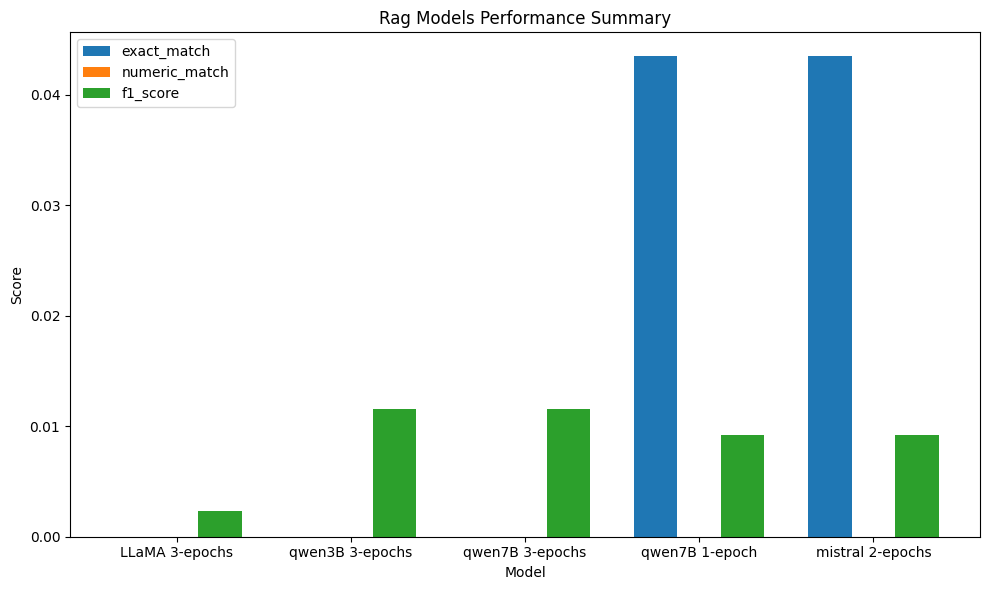

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["exact_match", "numeric_match", "f1_score"]

# X positions for each model
x = np.arange(len(df["model"]))

# Width of each bar
width = 0.25

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, df[metric], width, label=metric)

# Titles & labels
plt.xticks(x + width, df["model"])
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("FT Models Performance Summary")
plt.legend()

plt.tight_layout()
plt.show()


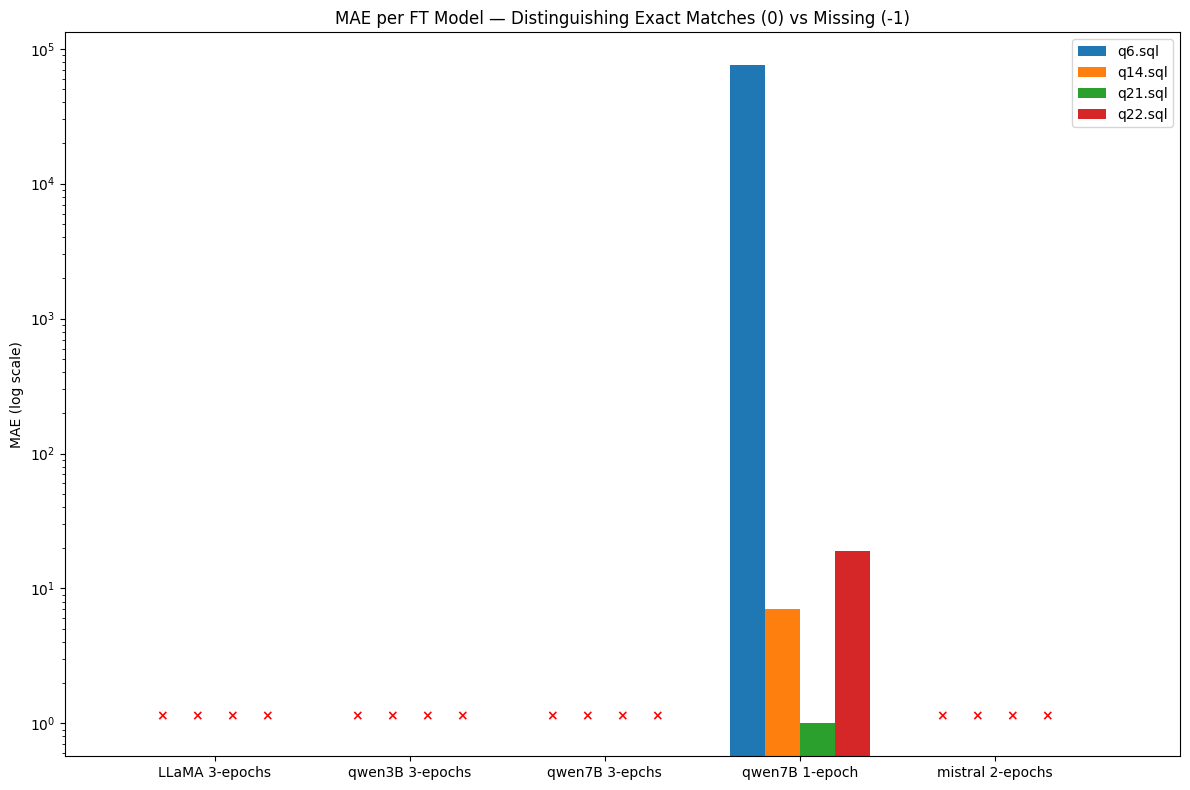

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
numeric_metrics_data = {
    "model": ["LLaMA 3-epochs", "qwen3B 3-epochs", "qwen7B 3-epchs", "qwen7B 1-epoch", "mistral 2-epochs"],
    "q6.sql": [-1, -1, -1, 75493.210, -1],
    "q14.sql": [-1, -1, -1, 7, -1],
    "q21.sql": [-1, -1, -1, 1, -1],
    "q22.sql": [-1, -1, -1, 19, -1],
}

df_2 = pd.DataFrame(numeric_metrics_data)

# Replace -1 with NaN for plotting
df_plot = df_2.replace(-1, np.nan)

metrics = ["q6.sql", "q14.sql", "q21.sql", "q22.sql"]
x = np.arange(len(df_2["model"]))
width = 0.18

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    values = df_plot[metric]

    # Plot bars normally
    bars = plt.bar(x + i*width, values, width, label=metric)

    for j, val in enumerate(values):
    # --- Mark missing values (NaN = no response) ---
        if np.isnan(val):
            # Place a red X above where the bar would be
            plt.text(
                x[j] + i*width,
                1,                     # y position (bottom of log scale)
                "×",
                ha="center",
                va="bottom",
                fontsize=10,
                color="red",
                fontweight="bold"
            )
        if val == 0:
            # Place a red X above where the bar would be
            plt.text(
                x[j] + i*width,
                1,                     # y position (bottom of log scale)
                "✓",
                ha="center",
                va="bottom",
                fontsize=10,
                color="green",
                fontweight="bold"
            )

plt.xticks(x + 1.5*width, df_2["model"])
plt.xlim(-0.5, len(x) - 0.5 + 4*width)  # Adjust x-axis limits to show all bars
plt.yscale("log")
plt.ylabel("MAE (log scale)")
plt.title("MAE per FT Model — Distinguishing Exact Matches (0) vs Missing (-1)")
plt.legend()

plt.tight_layout()
plt.show()
